In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import pickle
import cv2
from constants import MOUSE_MOVEMENT_NN_SCALE_DOWN
import matplotlib.pyplot as plt

In [2]:
#data0 = pickle.load(open('./data/data0.pkl', 'rb'))
data1 = pickle.load(open('./data/data1.pkl', 'rb'))
data2 = pickle.load(open('./data/data2.pkl', 'rb'))
data3 = pickle.load(open('./data/data3.pkl', 'rb'))
data4 = pickle.load(open('./data/data4.pkl', 'rb'))
data5 = pickle.load(open('./data/data5.pkl', 'rb'))

In [65]:
#frames, keyboard_data, mouse_data, cursor_positions = data2

In [3]:
# unpack and add data together
frames = []
keyboard_data = []
mouse_data = []
cursor_positions = []
for data in [data1, data2, data3, data4, data5]:
    frames += data[0]
    keyboard_data += data[1]
    mouse_data += data[2]
    cursor_positions += data[3]

In [4]:
len(frames), len(keyboard_data), len(mouse_data), len(cursor_positions)

(12365, 12365, 12365, 12365)

In [4]:
data = []
for i in range(len(keyboard_data)-1):
    action = []
    mouse_dx = 0
    mouse_dy = 0
    leftclick = 0
    space = 0
    for entry in mouse_data[i]:
        mouse_dx += entry.lLastX
        mouse_dy += entry.lLastY
        if entry.union.structure.usButtonFlags == 1 and leftclick == 0:
            leftclick = 1
        elif entry.union.structure.usButtonFlags == 2 and leftclick == 0:
            leftclick = -1

    for entry in keyboard_data[i]:
        if entry[1] == 1:
            space = -1
        elif entry[1] == 0:
            space = 1

    #action.append(mouse_dx/MOUSE_MOVEMENT_NN_SCALE_DOWN)
    #action.append(mouse_dy/MOUSE_MOVEMENT_NN_SCALE_DOWN)
    action.append(cursor_positions[i+1][0]/1920-0.5)
    action.append(cursor_positions[i+1][1]/1080-0.5)
    data.append(action)

In [9]:
labels = np.array(data)
print(labels.shape)

(12364, 2)


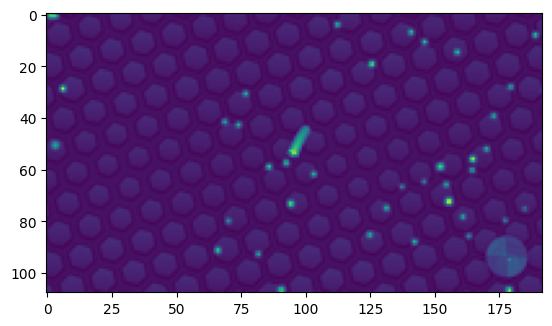

In [120]:
img = frames[100]
plt.imshow(img)

In [74]:
type(frames[0])

PIL.Image.Image

In [5]:
# gray scale each image
for i in range(len(frames)):
    # convert from PIL image to cv2 image
    img = np.array(frames[i])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    frames[i] = img

In [79]:
frames[i].shape

(108, 192)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 15),
            nn.ReLU(),
            nn.Linear(15, 2)
        )


    def forward(self, input):
        x = self.convs(input)
        x = x.view(x.size(0), -1)
        #print(x.shape, cursor_position.shape)
        x = self.fc(x)
        x = self.fc2(x)
        return x

In [7]:
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
loss = nn.MSELoss()

In [274]:
label = torch.tensor(labels[100]).unsqueeze(0).float()
cursor_position = torch.tensor([cursor_positions[0][0]/1920, cursor_positions[0][1]/1080]).unsqueeze(0).float()
label, cursor_position

(tensor([[ 0.1733, -0.0500,  0.0000,  0.0000]]), tensor([[0.4208, 0.3685]]))

In [133]:
len(frames) // 50

247

In [10]:
frames = np.array(frames, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)
cursor_positions = np.array(cursor_positions, dtype=np.float32)

In [190]:
cursor_positions[0:5][1]

array([808, 398])

In [271]:
bruh = torch.tensor(cursor_positions[0:50], dtype=torch.float32)
bruh[:, 0]  = bruh[:, 0] / 1920.0
bruh[:, 1] = bruh[:, 1] / 1080.0

In [205]:
label = labels[0*50:0*50+50]
label.shape

(50, 4)

In [280]:
12000 / 160

75.0

In [249]:
frames.shape, frames.dtype

((12365, 108, 192), dtype('float32'))

In [11]:
net = net.to('cuda')
loss = loss.to('cuda')

In [19]:
BATCH_SIZE = 20

In [20]:
20 * 600

12000

In [15]:
losses = []

In [27]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)

In [28]:
for epoch in range(250):
    for i in range(600):
        img = frames[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]
        label = labels[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]
        

        img = torch.tensor(img).squeeze().squeeze().unsqueeze(1).float()
        label = torch.tensor(label).squeeze().float()
        # bruh = torch.tensor(cursor_positions[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE], dtype=torch.float32)
        # bruh[:, 0]  = bruh[:, 0] / 1920.0 - 0.5
        # bruh[:, 1] = bruh[:, 1] / 1080.0 - 0.5      
        
        # move to cuda
        img = img.to('cuda')
        label = label.to('cuda')
        # bruh = bruh.to('cuda')

        output = net(img)
        l = loss(output, label)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        losses.append(l.item())

        # average loss of past 100
        if len(losses) > 100:
            losses.pop(0)
        avg_loss = sum(losses) / len(losses)

        print(epoch, i, l.item()*100, avg_loss*100, end="\r")
        

KeyboardInterrupt: 

In [24]:
# save model
torch.save(net.state_dict(), './model/slither5.pt')